In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('temperature.csv')

In [3]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [4]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [5]:
df['Date'] = df.apply(parse_date, axis=1)

In [6]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [7]:
# keep only columns we want
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [8]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

In [9]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

In [10]:
joined = auckland.join(stockholm, how='outer') # has some missing data

In [11]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [12]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [13]:
joined_part.interpolate(inplace=True)

In [14]:
joined_part.isna().sum() #

AucklandTemp     0
StockholmTemp    0
dtype: int64

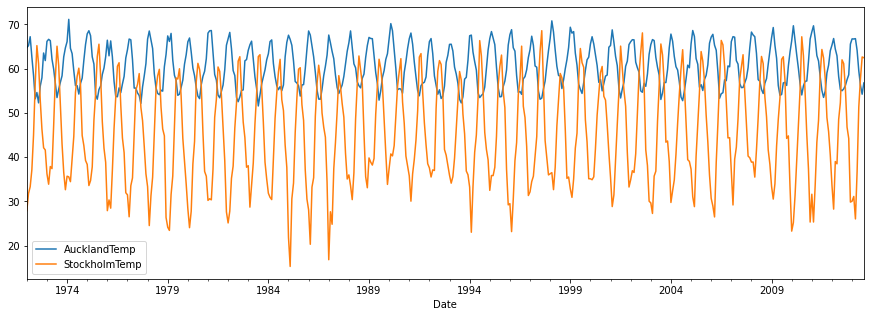

In [15]:
joined_part.plot(figsize=(15, 5));

In [16]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [17]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
    train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [18]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(
    train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [19]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [20]:

# put them back in original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

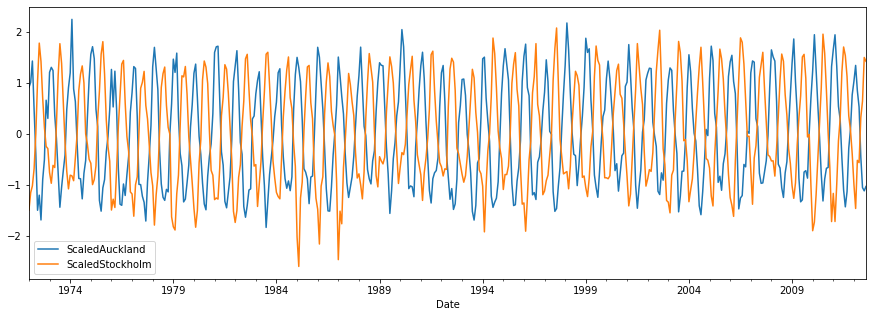

In [21]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(15, 5));

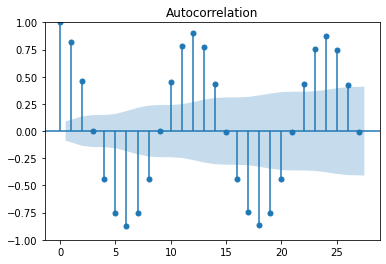

In [22]:
plot_acf(train['ScaledAuckland']);

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


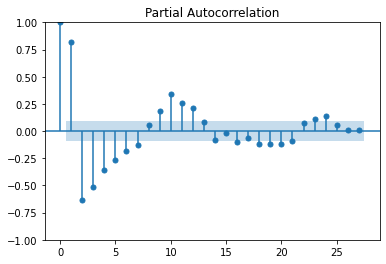

In [23]:
plot_pacf(train['ScaledAuckland']);

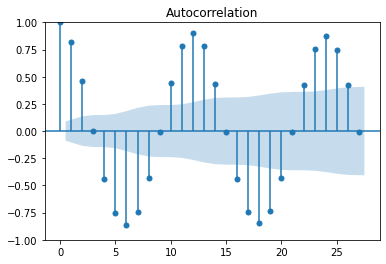

In [24]:
plot_acf(train['ScaledStockholm']);

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


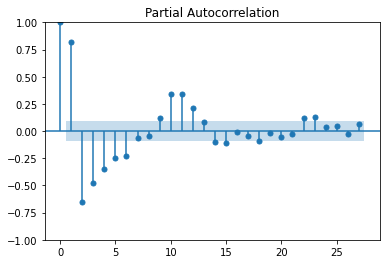

In [25]:
plot_pacf(train['ScaledStockholm']);

In [26]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           85     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88166D-01    |proj g|=  4.98695D-01

At iterate    5    f=  2.74661D-01    |proj g|=  1.76113D-01

At iterate   10    f=  2.57041D-01    |proj g|=  1.21188D-01

At iterate   15    f=  2.43906D-01    |proj g|=  1.86507D-01

At iterate   20    f=  2.28385D-01    |proj g|=  1.44935D-01

At iterate   25    f=  2.16511D-01    |proj g|=  4.70615D-02

At iterate   30    f=  2.12106D-01    |proj g|=  7.70652D-02

At iterate   35    f=  2.06768D-01    |proj g|=  1.99253D-01

At iterate   40    f=  2.05102D-01    |proj g|=  2.68735D-01

At iterate   45    f=  2.03225D-01    |proj g|=  1.47633D-01

At iterate   50    f=  2.01826D-01    |proj g|=  6.17046D-02

At iterate   55    f=  1.99276D-01    |proj g|=  1.99302D-01

At iterate   60    f=  1.96969D-01    |proj g|=  9.06804D-02

At iterate   65    f=  1.9

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:06:05.968460


In [27]:
fcast = res.get_forecast(Ntest)

In [28]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast.predicted_mean['ScaledAuckland']

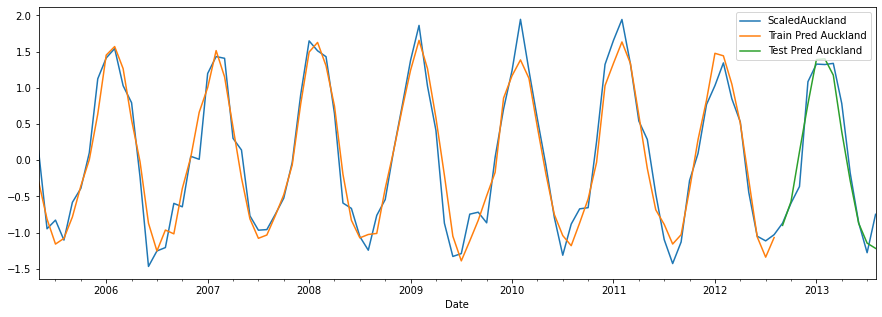

In [29]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [30]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast.predicted_mean['ScaledStockholm']

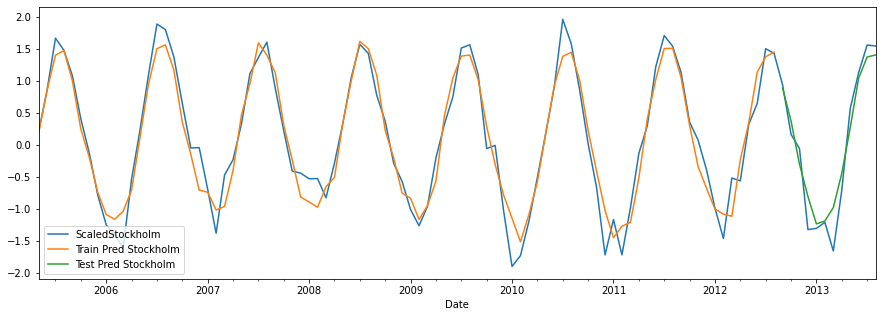

In [31]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [32]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9293990242551554
Auckland Test R^2: 0.9318516559076723


In [33]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9246622726688747
Stockholm Test R^2: 0.9316832335853794


In [34]:
model = VAR(train[cols])
lag_order_results = model.select_order(maxlags=15)
lag_order_results


In [35]:
lag_order_results.selected_orders



{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

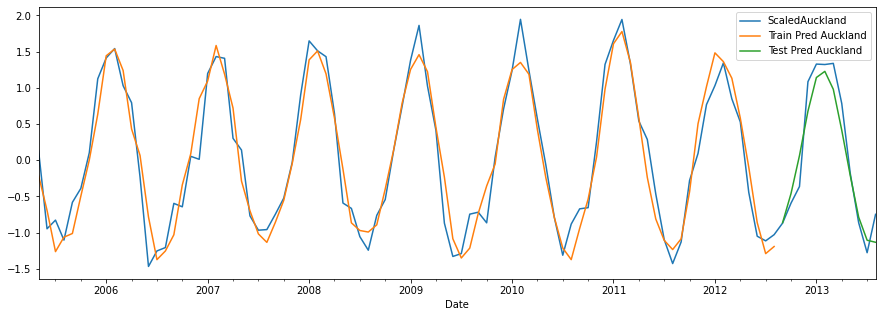

In [36]:
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar
prior = train.iloc[-lag_order:][cols].to_numpy() # why need this?
fcast = results.forecast(prior, Ntest)
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

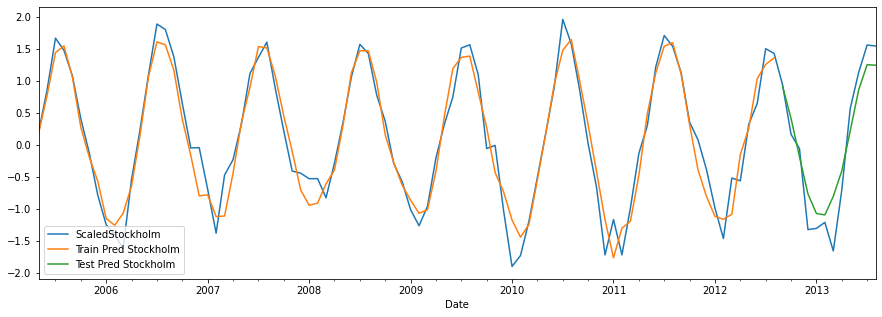

In [37]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [38]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340894


In [39]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204872


In [40]:
from statsmodels.tsa.arima.model import ARIMA

In [41]:
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213758206305763
ScaledAuckland Test R^2: 0.9380639089639694
ScaledStockholm Train R^2: 0.9207452851619865
ScaledStockholm Test R^2: 0.9482981284081262


/Users/stefanduprey/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
